In [1]:
import os
import wfdb
import pickle
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import load_model
import seaborn as sns
from utils import drop_repeat,cal_cross_validated,generate_marker,BlurPooling1D
np.set_printoptions(suppress=True)
from keras.utils import CustomObjectScope
%matplotlib inline

/Users/hu/.pyenv/versions/3.6.6/envs/Biosignals/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/hu/.pyenv/versions/3.6.6/envs/Biosignals/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Using TensorFlow backend.


In [2]:
result_df = pd.read_csv("final_result.csv",index_col="idx")
result_df = result_df.drop('Unnamed: 0',axis=1)

result_df_crossed = pd.read_csv("final_result_crossed.csv")
result_df_crossed = result_df_crossed.drop('Unnamed: 0',axis=1)

In [3]:
result_df_crossed

,pool_factor,pool_type,marker,loss,accuracy,consis_b,consis_ub,consis_n,consis_a,consis_a_s
0,1,max,$M$,0.713934,0.861072,0.834626,0.794545,0.833367,0.787874,0.835886
1,1,avg,$A$,0.742720,0.803283,0.791578,0.793278,0.725950,0.805828,0.857205
2,1,maxblur-1,o,0.666554,0.850241,0.830813,0.761357,0.847625,0.745346,0.814000
3,1,maxblur-2,|,0.698139,0.850962,0.838633,0.808865,0.816467,0.807926,0.860799
4,1,maxblur-3,^,0.647956,0.865392,0.857947,0.802245,0.855034,0.792787,0.860861
5,1,maxblur-4,D,0.623882,0.866571,0.848593,0.832316,0.834662,0.832080,0.862523
6,1,maxblur-5,p,0.537061,0.850514,0.839456,0.776680,0.874656,0.758661,0.804257
7,1,maxblur-6,h,0.521779,0.856051,0.848762,0.831136,0.812007,0.834426,0.885516
8,1,maxblur-7,*,0.472173,0.875873,0.866577,0.867690,0.843172,0.872402,0.889983
9,2,max,$M$,1.368572,0.805437,0.767876,0.705843,0.849199,0.679532,0.686554


In [43]:
def plot_improvement(df,method="maxblur-7",baseline="max",x="accuracy",y="consis_b"):
    plt.figure(figsize=(9,7))
    plt.title("Maxblur Pooling improvements compared to baseline",fontsize=20)
    for pool_factor in [1,2,3]:
        if pool_factor == 1:
            c = "b"
        elif pool_factor == 2:
            c = "r"
        else:
            c = "purple"
        label_method = str(pool_factor)+"-layer CNN " + method
        label_baseline = str(pool_factor)+"-layer CNN " + baseline
        start_x = df[(df.pool_factor==pool_factor)&(df.pool_type==baseline)][x]
        start_y = df[(df.pool_factor==pool_factor)&(df.pool_type==baseline)][y]
        end_x = df[(df.pool_factor==pool_factor)&(df.pool_type==method)][x]
        end_y = df[(df.pool_factor==pool_factor)&(df.pool_type==method)][y]
        plt.scatter(start_x,start_y,edgecolors=c,marker="o",c="w",label=label_baseline,s=200)
        
        #plt.scatter(end_x,end_y,edgecolors=c,marker="o",c=c,label=label_method,s=200)
        #plt.annotate('', xy=[end_x,end_y],xytext=[start_x,start_y],
        #    arrowprops=dict(headwidth=10,
        #                    connectionstyle='arc3',
        #                    facecolor=c, 
        #                    edgecolor=c))
        
    plt.xlabel("Accuracy",fontsize=20)
    plt.ylabel("Consistency",fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim(0.76,0.88)
    plt.ylim(0.76,0.88)
    plt.legend(fontsize=15,loc="upper left")

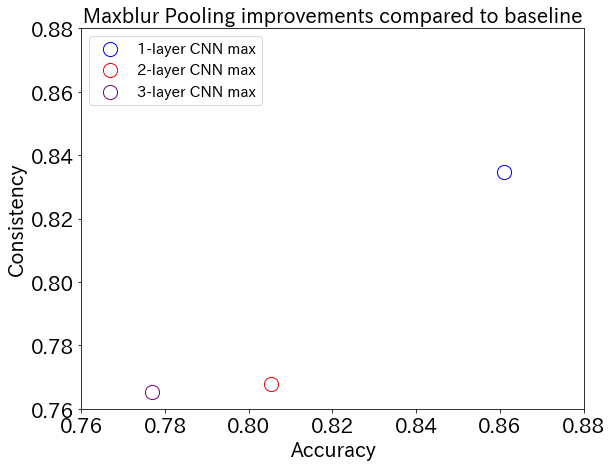

In [44]:
plot_improvement(df=result_df_crossed,baseline="max",method="maxblur-7")

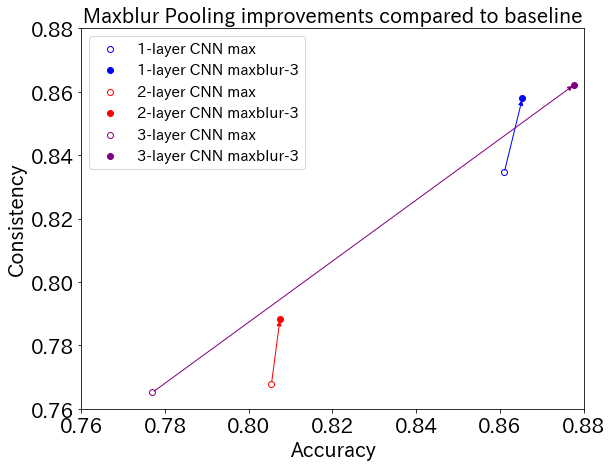

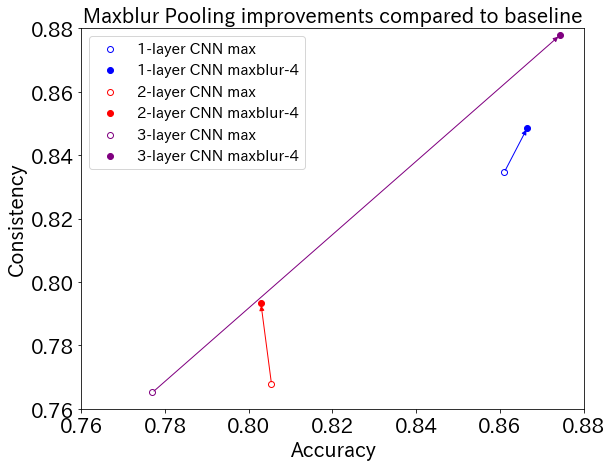

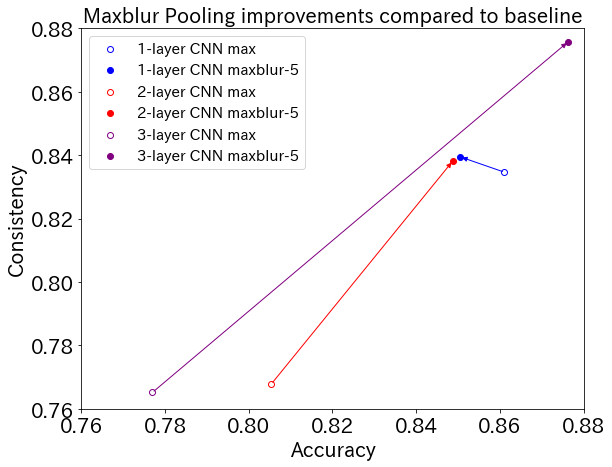

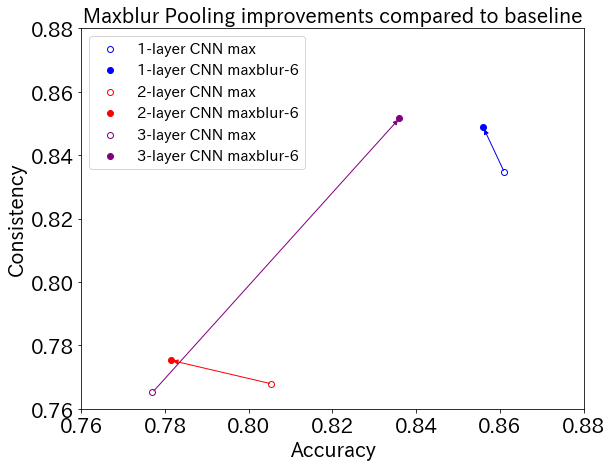

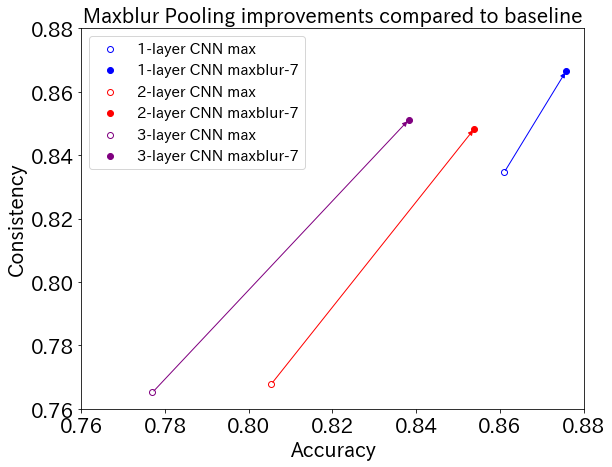

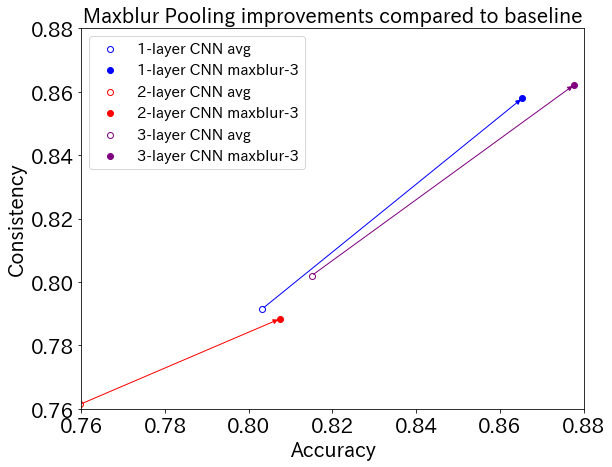

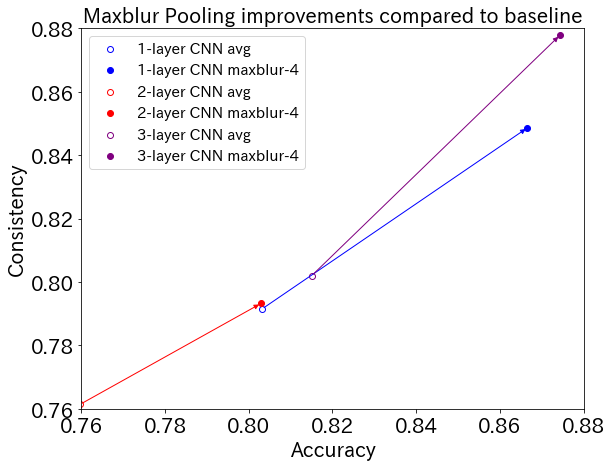

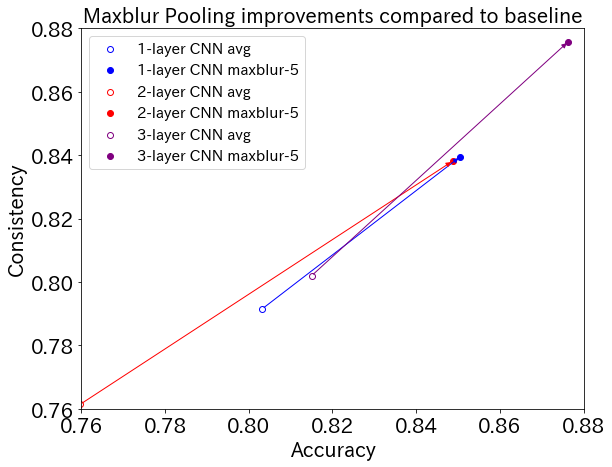

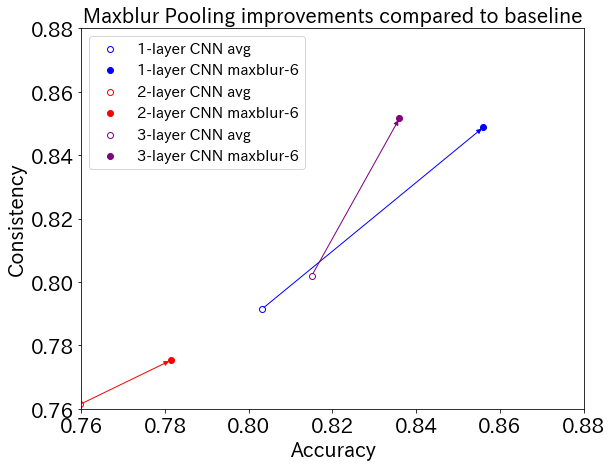

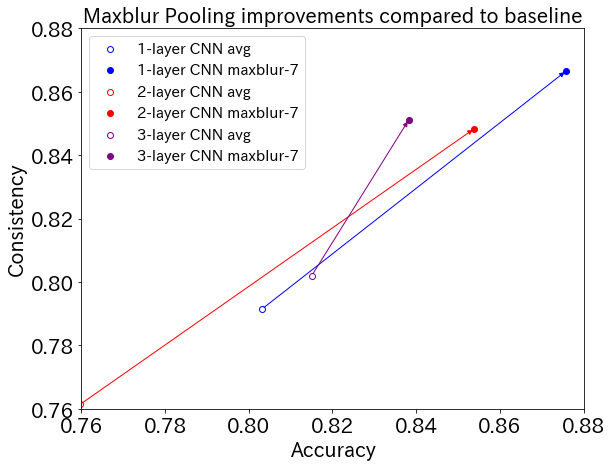

In [80]:
for baseline in ["max","avg"]:
    for method in ["maxblur-" + str(i+3) for i in range(5)]:
        plot_improvement(df=result_df_crossed,baseline=baseline,method=method)
        save_path = os.path.join("figs/",method+" vs "+baseline+".png")
        plt.savefig(save_path)